# 250 SFM, 0.002 IPT 

1528 RPM = 25.5 Hz

102 Hz for the tooth-pass frequency

In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf
from scipy.stats import describe

from scipy.stats import probplot
from scipy.stats import normaltest

from joblib import dump, load

from scipy import signal

# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [2]:
def extract_features(values):
    _,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='density')
#     amps /= 0.01
    amps = lin_log_interp(amps)
    
    _,minmax,mean,variance,skewness,kurtosis = describe(values,axis=1)
    mean = mean[...,np.newaxis]
    variance = variance[...,np.newaxis]
    skewness = skewness[...,np.newaxis]
    kurtosis = kurtosis[...,np.newaxis]
    
    sampleRMS = np.sqrt(1 / values.shape[0] * np.sum((values - np.repeat(mean,values.shape[1],axis=1).reshape(mean.shape[0],values.shape[1]))**2,axis=1))
    
    sampleRMS = sampleRMS[...,np.newaxis]
    
    print(mean.shape,variance.shape,skewness.shape,kurtosis.shape,sampleRMS.shape)
    stats = np.hstack((mean,variance,skewness,kurtosis,sampleRMS))
    
    return amps,stats


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [3]:
samples_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')

In [4]:
sfm_args = np.argwhere((samples_train[:,0] == 250/300)).flatten()
ipt_args = np.argwhere((samples_train[:,1] == 0.002/0.003)).flatten()
doe_args = sfm_args[np.argwhere([sfm_args == ipt_args[i] for i in range(ipt_args.shape[0])])[:,1]]
depth_args = np.argwhere((samples_train[:,2] == 25/25)).flatten()
doe_args = depth_args[np.argwhere([depth_args == doe_args[i] for i in range(doe_args.shape[0])])[:,1]]
# samples_selected = samples_selected[depth_args]
# doe_args = doe_args[np.argwhere([depth_args == doe_args[i] for i in range(doe_args.shape[0])])[:,1]]

In [5]:
first_unhealthy = 156

In [6]:
healthy_args = doe_args[doe_args < first_unhealthy]
unhealthy_args = doe_args[doe_args > first_unhealthy]

In [7]:
healthy_args = healthy_args[healthy_args != 112]

In [8]:
freqs = np.linspace(0,1.,2048) * 10000

In [9]:
DoE_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')
trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
X_train_original,stats_train_original = extract_features(X_train,)

stats_train_unhealthy = stats_train_original[unhealthy_args,:]
stats_train_healthy = stats_train_original[healthy_args,:]
X_train_unhealthy = X_train_original[unhealthy_args,:]
X_train_healthy = X_train_original[healthy_args,:]

DoE_train_healthy = DoE_train[healthy_args,:]
DoE_train_unhealthy = DoE_train[unhealthy_args,:]


Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))

stats_train = np.vstack((stats_train_healthy,stats_train_unhealthy))

Y_train = XY_train[:,-1]
columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']

X = []
X.append(X_train_healthy)
X.append(X_train_unhealthy)

DoE = []
DoE.append(DoE_train_healthy)
DoE.append(DoE_train_unhealthy)

stats = []
stats.append(stats_train_healthy)
stats.append(stats_train_unhealthy)
freqs = np.linspace(0,10000,2048)


(306, 1) (306, 1) (306, 1) (306, 1) (306, 1)


In [10]:
np.amax(X_train)
np.amin(X_train)

-2.42748

In [11]:
def plot_scores(score,delta_f,filename='scores'):
    yi = np.arange(-0.0, score.shape[0]) + 2
    xi = (np.arange(0.0,score.shape[1]) + 2) * delta_f

    X, Y = np.meshgrid(xi, yi)

    plt.figure(figsize=(12,4))
    ax = plt.gca()
    plt.pcolormesh(X,Y,score,cmap='cividis',norm=colors.Normalize(vmin=np.amin(score),vmax=np.amax(score)))
    cbar = plt.colorbar()
    cbar.set_label(r'\textbf{Normalized Score}', rotation=270,labelpad=20)
    plt.ylabel(r'\textbf{PCA Dimensions}', labelpad=5,fontsize=22)
    plt.xlabel(r'\textbf{PSD Bandwidth (Hz)}', labelpad=5,fontsize=22)
    
    plt.tight_layout(pad=1.2)
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

def box_plot_compare(data,labels,legend,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',
             xtickpad=5,showfliers=False,legend_loc='best',max_cutoff=0,min_cutoff=0,plot_type='violin'):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
        
    position = [i+1 for i in range(len(data))]
    tickPositions = []
    phantomLines = []
        
    for i in range(data[0].shape[1]):
        
        thisData = [data[j][:,i] for j in range(len(data))]

        bp = plt.boxplot(thisData,
                        positions=position,
                        showfliers=showfliers,
                        patch_artist=True,
                        meanline=False,
                        notch=False,
                        medianprops={'color':'black',
                                     'linewidth':2},
                        whiskerprops={'linewidth':2},
                        capprops={'linewidth':2},
                        widths=0.75)

        for counter,patch in enumerate(bp['boxes']):
            # change outline color
            patch.set(color=colors[counter], linewidth=2)
            patch.set_facecolor(colors[counter])

            if i == 0:
                line, = plt.plot([1,1],color=colors[counter])
                phantomLines.append(line)
            
        tickPositions.append(np.mean(position))    
        position = [position[i] + len(data) + 1 for i in range(len(position))]
            
    ax = plt.gca()

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    ax.set_xticks(tickPositions)
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    ax.legend(tuple(phantomLines),tuple(legend),loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    
    [phantomLines[i].set_visible(False) for i in range(len(phantomLines))]
    
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    

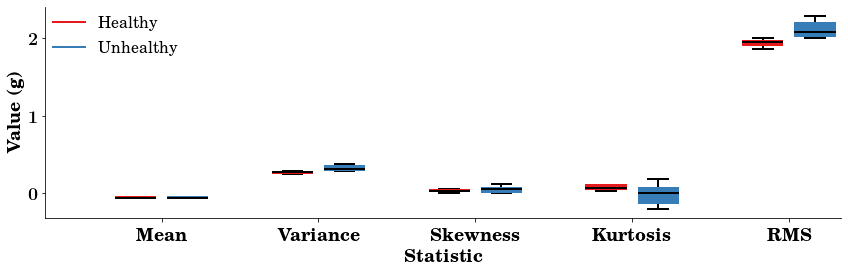

In [12]:
box_plot_compare(stats,['Mean','Variance','Skewness','Kurtosis','RMS'],['Healthy','Unhealthy'],savefig=True,filename='Time-Domain_Single-Compare',
         template='wide',xlabel='Statistic',color_order=np.zeros(6).astype(int),ylabel='Value (g)',
         showfliers=False,legend_loc='upper left',max_cutoff=2,plot_type='box',
         log_y=False)

In [13]:
print(np.mean(stats[0],axis=0))
print(np.mean(stats[1],axis=0))
print(np.std(stats[0],axis=0))
# X_unhealthy = X_train_original[unhealthy_args,:]
# X_healthy = X_train_original[healthy_args,:]
# X_unhealthy.shape
freqs,X_unhealthy = signal.welch(X_train[unhealthy_args,:], fs=20e3, nperseg=4096, scaling='density')
freqs,X_healthy = signal.welch(X_train[healthy_args,:], fs=20e3, nperseg=4096, scaling='density')
# print(amps.shape)

[-0.05424334  0.27307835  0.03108359  0.10830875  1.9351866 ]
[-0.05438058  0.3269646   0.0481901  -0.0173848   2.115873  ]
[0.00133185 0.01344236 0.0165815  0.09249141 0.04787182]


ValueError: Failed to parse /usr/share/texlive/texmf-dist/fonts/enc/dvips/base/8r.enc as Postscript encoding

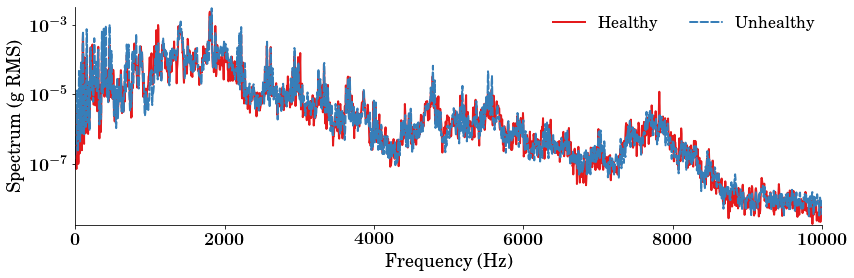

In [17]:
np.mean(X[0],axis=0).shape

# combine the responses and labels to put on our 2D plot
responses = np.vstack((np.mean(X_healthy,axis=0)[:],np.mean(X_unhealthy,axis=0)[:]))
labels = ['Healthy','Unhealthy']

numPoints = 200

# Create a 2D plot
genplt.generate_plot(freqs[:], # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Frequency (Hz)',# X - axis label
              'Spectrum (g RMS)',   # Y - axis label
              filename='FFT_Signal_Compare',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
                     log_y=True,
                     ymin=0.05,
              transparent=True,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='svg'
             )

